Clustering
===
Bothound project. 

In [1]:
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist,pdist
from scipy.signal import argrelextrema
from IPython.display import HTML

%matplotlib inline
from pylab import *
from numpy import *
from mpl_toolkits.mplot3d import axes3d
from matplotlib import pyplot as plt


%matplotlib inline
import matplotlib.pyplot as plt


features = [
            "request_interval", #0
            #"ua_change_rate",#1
            #"html2image_ratio",#2
            #"variance_request_interval",#3
            "payload_average",#4
            #"error_rate",#5
            "request_depth",#6
            #"request_depth_std",#7
            "session_length",#8
            "percentage_cons_requests",#9
            ]
columns = []
for f in features:
    columns.append((f, 'float'))


In [10]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import notebook
E = notebook.nbextensions.EnableNBExtensionApp()
E.enable_nbextension('usability/codefolding/main')

# Read the features from file

In [4]:
# Read from file
np.zeros([30000, 2000])
len(np.zeros([30000, 2000]))
# the original file is here: https://github.com/ludost11/justhackdeflect/blob/master/feature_db-files.txt
filename = '../data/feature_db-files.txt'
file = open(filename)


values =[]   
for line in file:
    splitted_line = line.split(') {')

    useful_part = splitted_line[1]
    useful_part = useful_part[:-2]
    new_split = useful_part.split(', ')

    num_list =[]   
    for b in new_split:
       c = b.split(': ')[1]
       num_list.append(float(c))
    values.append(num_list)
    
X = np.array(values)
#X = np.array(values)
print X.shape

(21664, 10)


# Read From Database

In [3]:
# Read from Database
import MySQLdb
id_incident = 19

#db = MySQLdb.connect(host = '127.0.0.1', user = 'root', passwd = '7k32uW+C!JMFXTRT', db = 'bothound')
db = MySQLdb.connect(host = '127.0.0.1', user = 'root', passwd = 'mazhur1n', port = 3306, db = 'bothound')
cur = db.cursor(MySQLdb.cursors.DictCursor)
cur.execute("select * from sessions WHERE id_incident = {0}".format(id_incident))
sessions = [dict(elem) for elem in cur.fetchall()]
db.close()

values = []
for s in sessions:
    row = []
    for f in features:
        row.append(s[f])
    values.append(row)
    
X = np.array(values)

print X.shape


(21664, 5)


# PCA

In [3]:
# perform PCA dimensionality reduction
pca = sklearn.decomposition.RandomizedPCA(n_components=3).fit(X)
X = pca.transform(X)

#totss = sum(pdist(X)**2)/X.shape[0]       # The total sum of squares
#print "totl ss", totss

# DBSCAN clustering

In [3]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=20).fit(X)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % num_clusters)

#plt.hist(labels, bins = num_clusters+1)


Estimated number of clusters: 50


# K-Means

In [22]:
import sklearn
from sklearn.cluster import KMeans

def get_best_clustering_model(X, max_number_of_clusters):
    cost = []
    KK = range(1,max_number_of_clusters+1)
    kms = []
    # calculate all the clustering and cost
    for no_of_clusters in KK:
        km = KMeans(n_clusters=no_of_clusters, precompute_distances = True, max_iter = 500, n_init = 30)
        km.fit(X)
        kms.append(km)

        #centroids = km.cluster_centers_ 
        #distances = cdist(X, centroids, 'euclidean')
        #cIdx = np.argmin(distances,axis=1) 
        #dist = np.min(distances,axis=1) 
        #tot_withinss = sum(dist**2)  # Total within-cluster sum of squares

        #cost.append(tot_withinss / X.shape[0]) 
        cost.append(km.inertia_)
    
    # calculate first derivative
    derivative1 = [cost[i+1]-cost[i] for i in range(len(cost)-1)]
    #print derivative1
        
    # calculate second derivative
    derivative2 = [derivative1[i+1]-derivative1[i] for i in range(len(derivative1)-1)]
    #print derivative2
    
    max2 = argrelextrema(np.argsort(derivative2), np.less) 
    num_clusters = 4 
    if(len(max2[0]) > 0):
        num_clusters = max2[0][0] + 3
    else:
        # calculate third derivative
        derivative3 = [derivative2[i+1]-derivative2[i] for i in range(len(derivative2)-1)]
        #print derivative3

        max3 = argrelextrema(np.argsort(derivative3), np.greater) 
        if(len(max3[0]) > 0):
            num_clusters = max3[0][0] + 4 
        
    return kms[num_clusters-1], cost

max_number_of_clusters = 10
model,cost = get_best_clustering_model(X, max_number_of_clusters)

labels = model.predict(X)

num_clusters = model.n_clusters
print "Num clusters:", num_clusters

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm

KK = range(1,max_number_of_clusters+1)

# elbow curve
kIdx = num_clusters      
clr = cm.spectral( np.linspace(0,1,10) ).tolist()
mrk = 'os^p<dvh8>+x.'

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(KK, cost, 'b*-')
ax.plot(num_clusters, cost[num_clusters-1], marker='o', markersize=14, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
#ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Number of clusters')
#plt.ylabel('Percentage of variance explained (%)')
plt.ylabel('Average within sum of squeres')
plt.title('Elbow for KMeans clustering')

color_set = [
[0, 0, 255],      #Blue
[255, 0, 0],      #Red
[0, 255, 0],      #Green
[255, 255, 0],    #Yellow
[255, 0, 255],    #Magenta
[255, 128, 128],  #Pink
[128, 128, 128],  #Gray
[128, 0, 0],      #Brown
[255, 128, 0],    #Orange
]

def get_colors(N=5):
    result = []
    for x in range(N):
        s = color_set[x % len(color_set)]
        result.append([s[0]/255.0,s[1]/255.0,s[2]/255.0,1])
    return result

palette = get_colors(num_clusters+1)


#cluster histogramm
sizes = [0]*model.n_clusters

for i in model.predict(X): 
    sizes[i] = sizes[i]+1
print sizes
index_max = sizes.index(max(sizes))

cluster_sizes = float(sizes[index_max])/ X.shape[0] * 100

#print cluster_sizes
left = [] 
for i in range(len(sizes)):
    left.append(i)
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(left,sizes, color = palette)


X_plot = X[labels >= 0,: ]
labels_plot = labels[labels >= 0]

colors = []
g = 0
for i in labels_plot:
    colors.append(palette[i])
    #colors.append(palette[g])
    #g = g + 1
    #if g == 8:
    #    g = 0
    
def plot3(indexes):
    fig = figure(figsize=(24,24))
    ax = fig.gca(projection='3d')
    #fig = plt.figure(figsize=(14,14))
    #ax = fig.add_subplot(111, projection='3d')

    ax.set_xlabel(features[indexes[0]])
    ax.set_ylabel(features[indexes[1]])
    ax.set_zlabel(features[indexes[2]])
    azim = 125
    elev = 15
    #ax.set_autoscale_on(False)
    #ax.axis([0.9, 1.5, -50, 50, 0, 400000])
    ax.view_init(elev, azim) 

    # plot points in 3D
    class1 = 0.6 * random.standard_normal((200,3))
    x = X_plot[:,indexes[0]]
    y = X_plot[:,indexes[1]]
    z = X_plot[:,indexes[2]]
    
    #x = random.random(len(colors))
    #y = random.random(len(colors))
    #z = random.random(len(colors))

    ax.scatter(x,y,z, s=5, edgecolors='none', c = colors, marker='o')

    #ax.set_xlim([0,10])
    #ax.set_ylim([0,1000000])
    #ax.set_zlim([0,30])
    
plot3([0,1,2])


SyntaxError: invalid syntax (<ipython-input-22-ad8454f7a39f>, line 52)

In [23]:
# %load "../src/bothound_tools.py"
"""
Utility class that holds commonly used Bothound functions

"""
import numpy as np

from sklearn.cluster import DBSCAN
import hashlib, hmac
import MySQLdb

from features.src.feature_geo import FeatureGEO
from features.src.feature_deflectee import FeatureDeflectee

from util.crypto import encrypt
import pdb

class BothoundTools():
    def connect_to_db(self):
        """
        This connetcion to the db will live for the live time of the
        learn2bantools instance and will be used to save data back to the db
        """
        self.db = MySQLdb.connect(host = self.db_host, user = self.db_user, 
            passwd = self.db_password,port = self.db_port)

        #Create cursor object to allow query execution
        self.cur = self.db.cursor(MySQLdb.cursors.DictCursor)
        sql = 'CREATE DATABASE IF NOT EXISTS ' + self.db_name
        self.cur.execute(sql)
        self.db.close()

        #Connect directly to DB
        self.db = MySQLdb.connect(host = self.db_host, user = self.db_user, 
            passwd = self.db_password, port = self.db_port, db = self.db_name)
        self.cur = self.db.cursor(MySQLdb.cursors.DictCursor)

        # ATTACKS table
        self.cur.execute("create table IF NOT EXISTS attacks (id INT NOT NULL AUTO_INCREMENT, "
        "comment LONGTEXT, "
        "PRIMARY KEY(id)) ENGINE=INNODB;")

       # INCIDENTS table
        self.cur.execute("create table IF NOT EXISTS incidents (id INT NOT NULL AUTO_INCREMENT, "
        "id_attack INT,"
        "start DATETIME, "
        "stop DATETIME, "
        "banjax_start DATETIME, "
        "banjax_stop DATETIME, "
        "comment LONGTEXT, "
        "processed BOOL,"
        "PRIMARY KEY(id)) "
        "ENGINE=INNODB;")

        try:
            self.cur.execute("ALTER TABLE incidents ADD target LONGTEXT;")
        except:
            pass

        try:
            self.cur.execute("ALTER TABLE incidents ADD cluster_index INT;")
        except:
            pass

        # SESSIONS table
        self.cur.execute("create table IF NOT EXISTS sessions (id INT NOT NULL AUTO_INCREMENT, "
        "id_incident INT NOT NULL, "
        "cluster_index INT, "
        "IP VARCHAR(45), "
        "IP_ENCRYPTED LONGTEXT, "
        "IP_IV LONGTEXT, "
        "IP_TAG LONGTEXT, "
        "request_interval FLOAT, " #Feature Index 1
        "ua_change_rate FLOAT, " #Feature Index 2
        "html2image_ratio FLOAT, " #Feature Index 3
        "variance_request_interval FLOAT, " #Feature Index 4
        "payload_average FLOAT, " #Feature Index 5
        "error_rate FLOAT, " #Feature Index 6
        "request_depth FLOAT, " #Feature Index 7
        "request_depth_std FLOAT, " #Feature Index 8
        "session_length FLOAT, " #Feature Index 9
        "percentage_cons_requests FLOAT," #Feature Index 10
        "latitude FLOAT," #Feature Index 11
        "longitude FLOAT," #Feature Index 12
        "id_country INT," #Feature Index 13
        "id_deflectee INT," #Feature Index 14
        "PRIMARY KEY(id), INDEX index_incicent (id_incident),  "    
        "FOREIGN KEY (id_incident) REFERENCES incidents(id) ON DELETE CASCADE ) ENGINE=INNODB;")

        # CLUSTERS table
        self.cur.execute("create table IF NOT EXISTS clusters (id INT NOT NULL AUTO_INCREMENT, "
        "id_incident INT NOT NULL, "
        "cluster_index INT NOT NULL, "
        "comment LONGTEXT, "
        "PRIMARY KEY(id), INDEX index_incicent (id_incident),  "
        "FOREIGN KEY (id_incident) REFERENCES incidents(id) ON DELETE CASCADE ) ENGINE=INNODB;")

        # DEFLECTEES table
        self.cur.execute("create table IF NOT EXISTS deflectees (id INT NOT NULL AUTO_INCREMENT, "
        "domain LONGTEXT, "
        "comment LONGTEXT, "
        "PRIMARY KEY(id)) ENGINE=INNODB;")

        # COUNTRIES table
        self.cur.execute("create table IF NOT EXISTS countries (id INT NOT NULL AUTO_INCREMENT, "
        "code LONGTEXT, "
        "name LONGTEXT, "
        "PRIMARY KEY(id)) ENGINE=INNODB;")

        # Intersections table
        self.cur.execute("create table IF NOT EXISTS intersections (id INT NOT NULL AUTO_INCREMENT, "
        "id_incident INT," 
        "id_incident2 INT," 
        "total INT, "
        "intersection FLOAT, " # (length of id_incident)*100/total
        "intersection2 FLOAT, " # (length of id_incident2)*100/total
        "PRIMARY KEY(id), INDEX index_incicent (id_incident),"
        "FOREIGN KEY (id_incident) REFERENCES incidents(id) ON DELETE CASCADE"
        ") ENGINE=INNODB;")

    def get_deflectees(self):
        self.cur.execute("select * from deflectees")
        return [dict(elem) for elem in self.cur.fetchall()]

    def get_countries(self):
        self.cur.execute("select * from countries")
        return [dict(elem) for elem in self.cur.fetchall()]

    """
    Post process features calculated by "lear2bat_feature" class instances
    """
    def post_process(self, ip_feature_db):
        # factorize the deflectees
        ip_feature_db = self.factorize_deflectees(ip_feature_db)

        # factorize the deflectees
        ip_feature_db = self.factorize_countries(ip_feature_db)

        return ip_feature_db

    """
    Replace domain string value in ip_feature_db with the appropriate 
    ID from deflectees table.
    Create new rows in deflectees table if necessary
    """
    def factorize_deflectees(self, ip_feature_db):
        deflectees = self.get_deflectees()

        ids = {}
        for d in deflectees:
            ids[d["domain"]] = d['id']

        feature_index = FeatureDeflectee({},{}).get_index()

        for ip in ip_feature_db:
            features = ip_feature_db[ip]
            domain = features[feature_index] 
            if(isinstance(domain, ( int, long ) ) == True):
                continue

            if(domain in ids):
                features[feature_index] = ids[domain]
            else:
                self.cur.execute("insert into deflectees(domain) values ('{}')".format(domain))
                ids[domain] = self.cur.lastrowid
                features[feature_index] = self.cur.lastrowid
                self.db.commit()

        return ip_feature_db
        
    """
    Replace country string value in ip_feature_db with the appropriate 
    ID from countreis table.
    Create new rows in countreis table if necessary
    """
    def factorize_countries(self, ip_feature_db):
        countries = self.get_countries()

        ids = {}
        for c in countries:
            ids[c["code"]] = c['id']

        feature_index = FeatureGEO({},{}).get_index() + 2

        for ip in ip_feature_db:
            features = ip_feature_db[ip]
            country_code = features[feature_index] 
            if(isinstance(country_code, ( int, long ) ) == True):
                continue

            if(country_code in ids):
                features[feature_index] = ids[country_code]
            else:
                self.cur.execute("insert into countries(code) values ('{}')".format(country_code))
                ids[country_code] = self.cur.lastrowid
                features[feature_index] = self.cur.lastrowid
                self.db.commit()

        return ip_feature_db

    def delete_sessions(self, id_incident):
        self.cur.execute("DELETE FROM sessions WHERE id_incident = {0}".format(id_incident))
        self.db.commit()

    def add_sessions(self, id_incident, ip_feature_db):
        for ip in ip_feature_db:

            insert_sql = "insert into sessions values (%s,%s,%s,%s,%s,%s,%s"
            features = ip_feature_db[ip]
            for feature in features:
                insert_sql += ",%s"
            insert_sql += ")"

            features = ip_feature_db[ip]
            ip_ascii = ip[0].encode('ascii','ignore')
            ip_enctypted = self.encrypt(ip_ascii)
            ip_hash = self.hash(ip_ascii)

            values = [0,id_incident,0, ip_hash, ip_enctypted[0], ip_enctypted[1], ip_enctypted[2]]
            for feature in features:
                values.append(features[feature])

            self.cur.execute(insert_sql, values)

        self.db.commit()

    def get_sessions(self, id_incident):
        self.cur.execute("select * from sessions WHERE id_incident = {0}".format(id_incident))
        return [dict(elem) for elem in self.cur.fetchall()]

    def set_incident_processed(self, id, processed):
        sql = "update incidents set processed={} WHERE id = {}".format(processed,id)
        self.cur.execute(sql)
        self.db.commit()

    def get_incidents(self, processed):
        self.cur.execute("select * from incidents WHERE "
        "cast(processed as unsigned) = %d" % (1 if processed else 0))
        return [dict(elem) for elem in self.cur.fetchall()]

    def get_incident(self, id):
        self.cur.execute("select * from incidents WHERE id = %d" % id)
        incident = None
        for row in self.cur.fetchall():
            incident = row
        return incident

    def get_processed_incidents(self):
        return self.get_incidents(True)

    def get_not_processed_incidents(self):
        return self.get_incidents(False)

    def update_geo(self, id_incident):
        self.cur.execute("select id, ip from sessions WHERE id_incident = {0}".format(id_incident))
        rows = self.cur.fetchall();
        for row in rows:
            match = FeatureGEO.find_location(row['ip'])
            sql = "update sessions set latitude={}, longitude={}, country='{}' WHERE id = {}".format(match['latitude'], match['longitude'], match['country'], row['id'])
            self.cur.execute(sql)

        self.db.commit()
        return

    def disconnect_from_db(self):
        """
        Close connection to the database
        """
        self.cur.close()
        self.db.close()

    def load_database_config(self, database_conf, elastic_db_conf):
        self.db_user = database_conf["user"]
        self.db_password = database_conf["password"]
        self.db_host = database_conf["host"]
        self.db_name = database_conf["name"]
        if("port" in database_conf):
            self.db_port = database_conf["port"]
        else:
            self.db_port = 3306

        self.db_encryption_key = hashlib.sha256(database_conf["encryption_passphrase"]).digest()
        self.db_hash_key = hashlib.sha256(database_conf["hash_passphrase"]).digest()

        #read elastic search user and password
        self.es_user = elastic_db_conf["user"]
        self.es_password = elastic_db_conf["password"]
        self.es_host = elastic_db_conf["host"]
        if("port" in elastic_db_conf):
            self.es_port = elastic_db_conf["port"]
        else:
            self.es_port = 9200

    def random_slicer(self, data_size, train_portion=0.5):
        """
        Return two arrays with random true and false and complement of each
        other, used for slicing a set into trainig and testing

        INPUT:
            data_size: size of the array to return
            train_portion: between 0,1 indicate the portion for the True
                           entry
        """
        from random import random
        random_selector = [random() < train_portion for i in range(0, data_size)]
        complement_selector = np.logical_not(random_selector)

        return random_selector, complement_selector

    """
    create a test incident and all the sessions from 
    ../data/feature_db-files.txt
    """
    def get_test_incident(self):

        test_comment = 'Test incident'
        #check if the test incident exists
        self.cur.execute("select id from incidents WHERE comment = '{0}'".format(test_comment))
        for row in self.cur.fetchall():
            print "test incident exists", row['id']
            return row['id']

        print "creating test incident..."

        #new incident record
        sql = "insert into incidents(comment) VALUES('%s')" % (test_comment)
        self.cur.execute(sql)

        id_incident = self.cur.lastrowid
        print "id_incident", id_incident

        filename = '../data/feature_db-files.txt'
        file = open(filename)
        line_number = 15000
        for line in file:
            splitted_line = line.split(') {')

            useful_part = splitted_line[1]
            useful_part = useful_part[:-2]
            new_split = useful_part.split(', ')

            insert_sql = "insert into sessions values (NULL," + str(id_incident) + ", 0, "
            insert_sql += "\"" + str(line_number) + "\","
            line_number = line_number + 1

            insert_sql += "0,0,0,"

            for b in new_split:
               c = b.split(': ')[1]
               insert_sql += str(c) + ","
                
            insert_sql += "0,0,0,0,"
            insert_sql = insert_sql[:-1]
            insert_sql += ");"
            self.cur.execute(insert_sql)

        self.db.commit()
        print "done."
        return id_incident

    """
    Cluster the sessions in the incident.
    Update cluster_index in session table
    Return the sessions with the calculated cluster_index
    """    
    def cluster(self, id_incident):
        sessions = self.get_sessions(id_incident)
        features = [
            "request_interval",
            "ua_change_rate",
            "html2image_ratio",
            "variance_request_interval",
            "payload_average",
            "error_rate",
            "request_depth",
            "request_depth_std",
            "session_length",
            "percentage_cons_requests",
            #"latitude",
            #"longitude"
            ]
        data_set = []
        for session in sessions:
            values = []
            for feature in features:
                values.append(session[feature])
            data_set.append(values)

        if len(data_set) == 0 :
            return

        X = np.array(data_set)

        # Compute DBSCAN
        db = DBSCAN(eps=0.1, min_samples=20).fit(X)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        print('Estimated number of clusters: %d' % n_clusters_)

        #update the cluster column in session table
        for session, label in zip(sessions, labels):
            session["cluster_index"] = label
            self.cur.execute('update sessions set cluster_index ={0} '
            'where id={1}'.format(label, session['id']))
        self.db.commit()
        return sessions


    def encrypt(self, data):
        return encrypt(self.db_encryption_key, data, "")

    def hash(self, data):
        return hmac.new(data, self.db_hash_key, hashlib.sha256).digest()

    def encrypt_and_hash(self, data):
        """
        This is mainly for storing IPs so we don't store them 
        in plain, we use hash so each ip converts to the same
        hash so we can get all the sessions related to an ip
        without knowing the ip

        INPUT:: a string containing the sensetive data

        OUTPUT:: (encrypted_sensetive_data, 
                  keyed_hash_of_sensetive_data)
        """
        return (self.encrypt(data), self.hash(data))
        
    def calculate_intersection(self, id_incident, id_incident2):
        # delete the previous calculations
        self.cur.execute("DELETE FROM intersections WHERE id_incident = {0}".format(id_incident))
        self.db.commit()

        self.cur.execute("select IP from sessions WHERE id_incident = {0}".format(id_incident))
        ips = [elem["IP"] for elem in self.cur.fetchall()]

        self.cur.execute("select IP from sessions WHERE id_incident = {0}".format(id_incident2))
        ips2 = [elem["IP"] for elem in self.cur.fetchall()]

        total = len(set(ips).intersection(ips2))

        #update the table
        sql = """INSERT INTO intersections (`id`, `id_incident`, `id_incident2`, `total`, 
        `intersection`, `intersection2`) VALUES ({},{},{},{},{},{})""".format(0,
        id_incident, id_incident2, total, total*100.0/len(ips), total*100.0/len(ips2))

        self.cur.execute(sql)
        self.db.commit()
        return 

    def calculate_all_intersections(self, id_incident):
        self.cur.execute("select * from incidents where id != {}".format(id_incident))
        for incident in self.cur.fetchall():
            self.calculate_intersection(id_incident, incident["id"])
        pass

    def __init__(self, conf):
        #we would like people to able to use the tool object even
        #if they don't have a db so we have no reason to load this
        #config in the constructor
        self.load_database_config(conf["database"], conf["elastic_db"])


SyntaxError: invalid syntax (<ipython-input-23-17df3a0b92b0>, line 320)

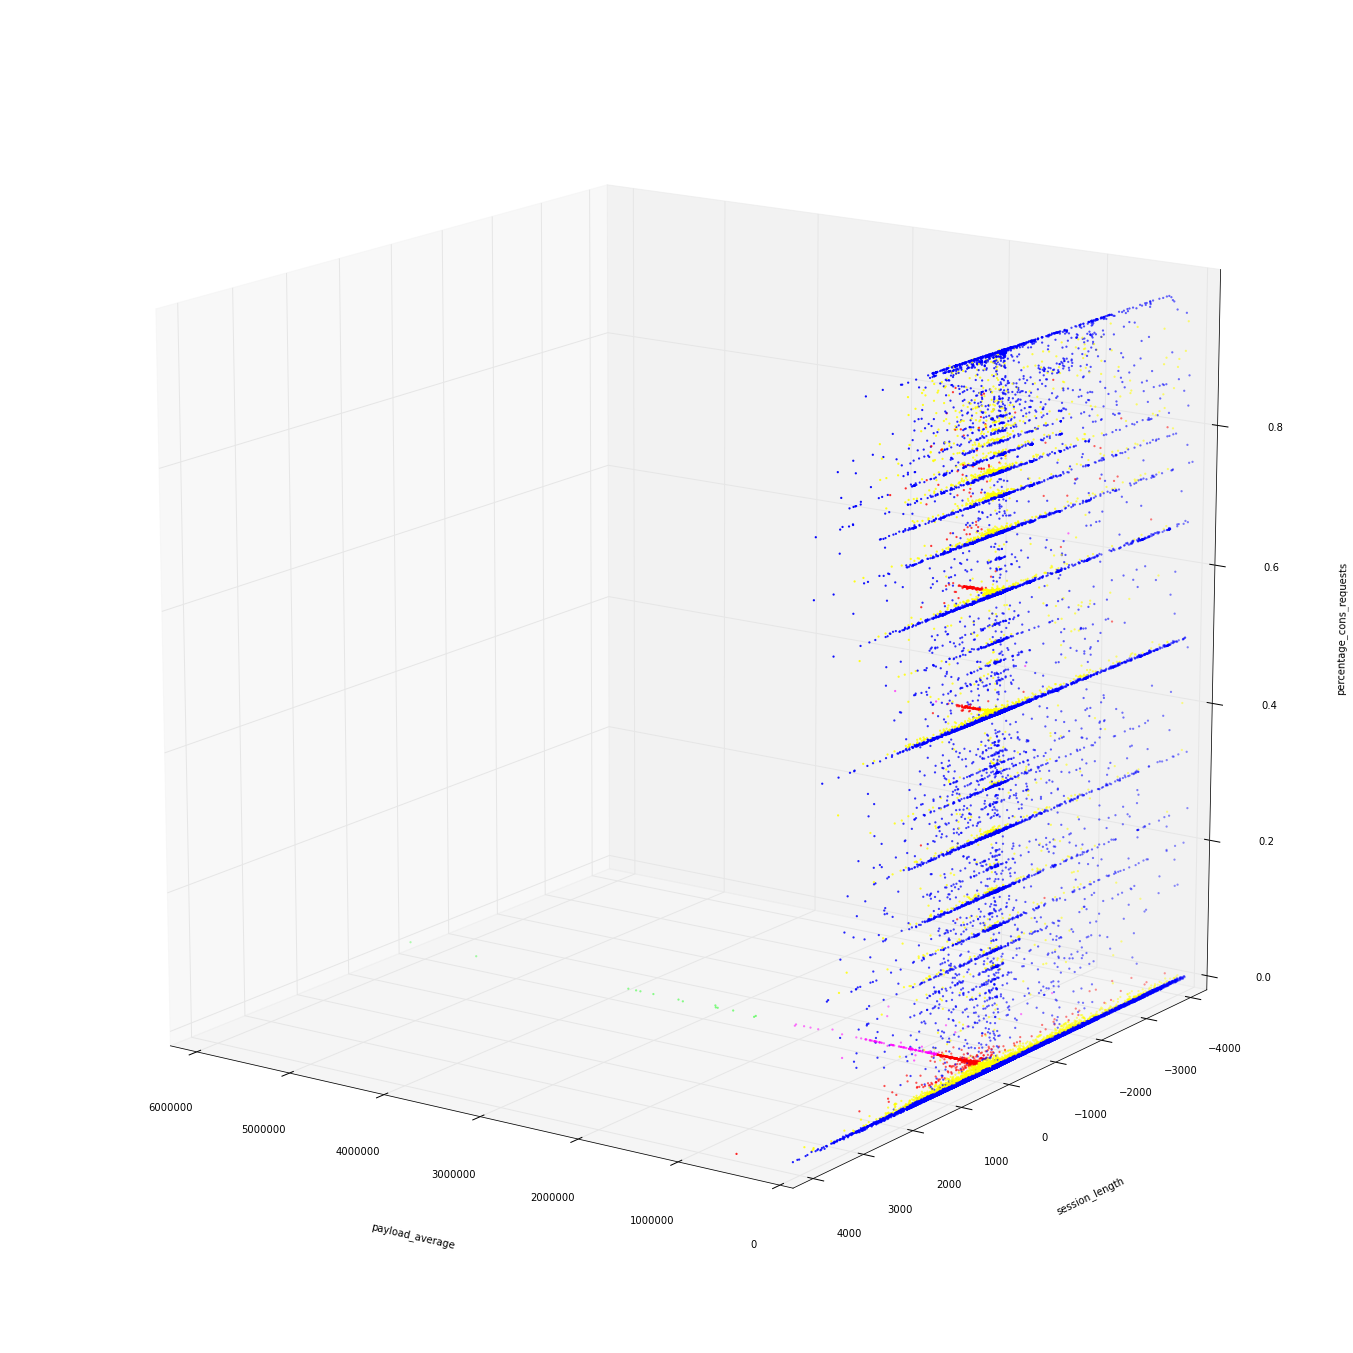

In [5]:
plot3([1,3,4])